# Convolution Network ------> food vs. non-food

In [4]:
# Adapted notebook from Author: Aymeric Damien
# Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [1]:
#util and imports
%matplotlib inline

import os
import fnmatch
from cStringIO import StringIO
import numpy as np
import PIL.Image
import IPython.display
import shutil
import matplotlib.pyplot as plt


def list_all_files(directory, extensions=None):
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined
                
def show_array(a, fmt='png', filename=None):
    a = np.uint8(np.clip(a, 0, 255))
    image_data = StringIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

def find_rectangle(n, max_ratio=2):
    sides = []
    square = int(math.sqrt(n))
    for w in range(square, max_ratio * square):
        h = n / w
        used = w * h
        leftover = n - used
        sides.append((leftover, (w, h)))
    return sorted(sides)[0][1]

# should work for 1d and 2d images, assumes images are square but can be overriden
def make_mosaic(images, n=None, nx=None, ny=None, w=None, h=None):
    if n is None and nx is None and ny is None:
        nx, ny = find_rectangle(len(images))
    else:
        nx = n if nx is None else nx
        ny = n if ny is None else ny
    images = np.array(images)
    if images.ndim == 2:
        side = int(np.sqrt(len(images[0])))
        h = side if h is None else h
        w = side if w is None else w
        images = images.reshape(-1, h, w)
    else:
        h = images.shape[1]
        w = images.shape[2]
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        ia = (i)*h
        ib = (i+1)*h
        for j in range(nx):
            ja = j*w
            jb = (j+1)*w
            mosaic[ia:ib, ja:jb] = next(image_gen)
    return mosaic

In [2]:
food = list(list_all_files('../../notebooks/projecte/UBdatascience/images_food_not_food/food/', ['.jpg']))
print 'loaded', len(food), "exemples de menjar"
not_food = list(list_all_files('../../notebooks/projecte/UBdatascience/images_food_not_food/not_food/', ['.jpg']))
print 'loaded', len(not_food), "exemples de no menjar"

examples = [(path, 0) for path in not_food] + [(path, 1) for path in food]

loaded 4805 exemples de menjar
loaded 8005 exemples de no menjar


In [3]:
import numpy as np
from skimage.measure import block_reduce
from skimage.io import imread
from skimage import transform

def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    size = 128
    for path, label in examples:        
        try:
            img = imread(path) #, as_grey=True 
            rows = img.shape[0]
            cols = img.shape[1]
            center = np.array([rows/2, cols/2])     

            if (rows>cols):
                crop_size = cols/2
                img = img[center[0]-crop_size:center[0]+crop_size,:,:]
            else : 
                crop_size = rows/2 
                img = img[:,center[1]-crop_size:center[1]+crop_size,:]

            img = transform.resize(img, (size,size,3))        
            img = block_reduce(img, block_size=(block_size, block_size,1), func=np.mean)
            img = img.reshape((64*64*3))
            X.append(img)

            if(label==0):
                y.append((1,0))
            else:
                y.append((0,1))
        except: 
            pass
    return np.asarray(X), np.asarray(y)

%time X, Y = examples_to_dataset(examples)
X = np.asarray(X,dtype=np.float32)/ 255.
Y = np.asarray(Y,dtype=np.int32)

CPU times: user 1min 31s, sys: 11.5 s, total: 1min 42s
Wall time: 3min 8s


In [4]:
X.shape

(12805, 12288)

In [5]:
# Split data into train and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=2)

In [6]:
#show some pics
#plt.imshow(255*make_mosaic(X[:len(food)], 8),cmap='gray') 

In [7]:
#show some pics
#plt.imshow(255*make_mosaic(X[:-len(food)], 8),cmap='gray') 

In [8]:
import tensorflow as tf

In [9]:
# Parameters
learning_rate = 0.0001
training_iters = 100
batch_size = 128
display_step = 20

In [10]:
# Network Parameters
n_input = 12288 # MNIST data input (img shape: 28*28)
n_classes = 2 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

In [12]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [13]:
# Create model
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def max_pool2(img, k):
    return tf.nn.max_pool(img, ksize=[1, 3, 3, 1], strides=[1, k, k, 1], padding='SAME')

def norm(l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

def conv_net2(_X, _weights, _biases):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 64, 64, 3])

    # Convolution Layer1
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    
    V = tf.slice(conv1, (0, 0, 0, 0), (1, -1, -1, -1), name='slice_first_input')
    V = tf.reshape(V, (64, 64, 96))
    # Reorder so the channels are in the first dimension, x and y follow.
    return tf.transpose(V, (2, 0, 1))
    # Bring into shape expected by image_summary
    #return tf.reshape(V, (-1, 64, 64, 1))

    
#AlexNet
def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 64, 64, 3])

    # Convolution Layer1
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    
    V = tf.slice(conv1, (0, 0, 0, 0), (1, -1, -1, -1), name='slice_first_input')
    V = tf.reshape(V, (64, 64, 96))

    # Reorder so the channels are in the first dimension, x and y follow.
    V = tf.transpose(V, (2, 0, 1))
    # Bring into shape expected by image_summary
    V = tf.reshape(V, (-1, 64, 64, 1))

    tf.image_summary("first_conv", V)
    
    # Max Pooling (down-sampling)
    conv1 = max_pool2(conv1, k=2)
    # Apply Normalization
    conv1 = norm(conv1, lsize=4)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    

    # Convolution Layer2
    conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool2(conv2, k=2)
    # Apply Normalization
    conv2 = norm(conv2, lsize=4)
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)
    
     # Convolution Layer3
    conv3 = conv2d(conv2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = max_pool(conv3, k=2)
    # Apply Normalization
    conv3 = norm(conv3, lsize=4)
    # Apply Dropout
    conv3 = tf.nn.dropout(conv3, _dropout)
    

    # Fully connected layer
    # Reshape conv3 output to fit dense layer input
    dense1 = tf.reshape(conv3, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
    #Relu 2
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd2']), _biases['bd2']))
    
    '''# Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout'''

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out

In [14]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 3 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 3, 96])), 
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 96, 192])), 
    # 5x5 conv, 1 input, 32 outputs
    'wc3': tf.Variable(tf.random_normal([3, 3, 192, 192])), 
    # fully connected, 8*8*128 inputs, 4096 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*192, 4096])), 
    # fully connected
    'wd2': tf.Variable(tf.random_normal([4096, 4096])), 
    # 1024 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([4096, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([96])),
    'bc2': tf.Variable(tf.random_normal([192])),
    'bc3': tf.Variable(tf.random_normal([192])),
    'bd1': tf.Variable(tf.random_normal([4096])),
    'bd2': tf.Variable(tf.random_normal([4096])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [15]:
biases['bc1']

In [16]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)
test = conv_net2(x, weights, biases)

In [17]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [18]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [19]:
# Initializing the variables
init = tf.initialize_all_variables()

In [20]:
#filter_summary = tf.image_summary('test',weights['wc1'])

In [21]:
# Launch the graph
with tf.Session() as sess: 
    #summary_writer = tf.train.SummaryWriter('tmp_conv/logs', sess.graph)
    #writer = tf.train.SummaryWriter("tmp/linear_regression", sess.graph)
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = X_train[(batch_size*(step-1)):batch_size*(step)],y_train[(batch_size*(step-1)):batch_size*(step)]
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
            #summary_writer.add_summary(acc[1], step)
        step += 1
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test[:], 
                                                             y: y_test, 

                                                             keep_prob: 1.})
    images_convolved = sess.run(test, feed_dict={x: X_train[0:3,...]})
    '''print "images:" , sess.run(x)'''
    '''result = sess.run(z, feed_dict={x: X_train[(batch_size*(step-1)):batch_size*(step)]})
    print(result)
    print "weights:", sess.run(weights['wc1'])
    print "biases:", sess.run(biases['bc1'])'''

Optimization Finished!
Testing Accuracy: 0.371585


In [22]:
images_convolved.shape

(96, 64, 64)

In [24]:
images_convolved[0].shape

(64, 64)

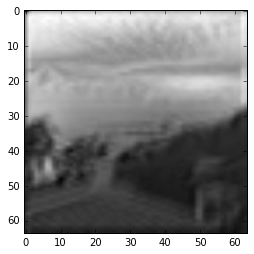

In [77]:
plt.imshow(images_convolved[50],cmap='gray')

In [33]:
X_train.shape

(11524, 12288)

In [41]:
from skimage.color import rgb2gray
image = X_train[0].reshape((64,64,3))
img_gray = rgb2gray(image)

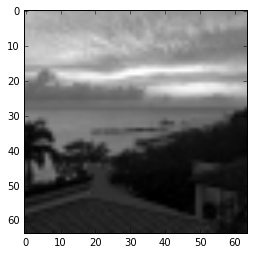

In [42]:
plt.imshow(img_gray,cmap='gray')

In [ ]:
img_gray = rgb2gray(img)
plt.imshow(X_train[0].reshape(64*64),cmap='gray')


In [81]:
batch_xs = X_train[(batch_size*(1-1)):batch_size*(1)]
x = tf.Variable(batch_xs)

In [22]:
_X = tf.reshape(x, shape=[-1, 64, 64, 3])
wc1 = tf.Variable(sess.run(weights['wc1']))


In [23]:
biases = tf.Variable(sess.run(biases['bc1']))

In [45]:
sess.run(biases[1])


FailedPreconditionError: Attempting to use uninitialized value Variable_14
	 [[Node: Variable_14/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_14"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_14)]]
Caused by op u'Variable_14/read', defined at:
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-d6dc5c522358>", line 1, in <module>
    biases = tf.Variable(sess.run(biases['bc1']))
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 211, in __init__
    dtype=dtype)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 831, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 704, in apply_op
    op_def=op_def)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2260, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/eredxiii/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1230, in __init__
    self._traceback = _extract_stack()


In [24]:
def test_conv(_X, wc1, biases):    
    conv1 = conv2d(_X, wc1, biases)
    V = tf.slice(conv1, (0, 0, 0, 0), (1, -1, -1, -1), name='slice_first_input')
    V = tf.reshape(V, (64, 64, 96))

    # Reorder so the channels are in the first dimension, x and y follow.
    V = tf.transpose(V, (2, 0, 1))
    # Bring into shape expected by image_summary
    V = tf.reshape(V, (-1, 64, 64, 1))

    tf.image_summary("first_conv", V)

In [26]:
test = test_conv(_X, wc1,biases)

In [28]:
sess.run(test, feed_dict={_X:_X,wc1:wc1,biases:biases})

TypeError: Fetch argument None of None has invalid type <type 'NoneType'>, must be a string or Tensor. (Can not convert a NoneType into a Tensor or Operation.)

In [ ]:


    # Convolution Layer1
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    
    V = tf.slice(conv1, (0, 0, 0, 0), (1, -1, -1, -1), name='slice_first_input')
    V = tf.reshape(V, (64, 64, 96))

    # Reorder so the channels are in the first dimension, x and y follow.
    V = tf.transpose(V, (2, 0, 1))
    # Bring into shape expected by image_summary
    V = tf.reshape(V, (-1, 64, 64, 1))

    tf.image_summary("first_conv", V)

In [41]:
sess.close()